# Intent Analysis

## Importing Libraries & Zemberek & Other Modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import re , os, pickle
from pathlib import Path
import time
import logging

from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)

import torch
import random
import torch.nn as nn
import transformers
import gc
import matplotlib.pyplot as plt
device = torch.device('cuda')
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Zemberek'i kullanabillmek için ilk önce java kütüphenelerini kullanmamızı sağlayan kütüphaneyi ekleyelim
import jpype as jp

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile

def read_jar(jar_file):
    zf = zipfile.ZipFile(jar_file, 'r')
    try:
        lst = zf.infolist()
        for zi in lst:
            fn = zi.filename 
            # print(fn)
    finally:
        zf.close()
        
read_jar(r"zemberek-full.jar")

In [ ]:
# Zembrek'i çalıştıralım
ZEMBEREK_PATH = r'zemberek-full.jar'
jp.startJVM(jp.getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))

In [10]:
# Zemberekten gerekli modülleri import edelim
TurkishTokenizer = jp.JClass('zemberek.tokenization.TurkishTokenizer')
TurkishMorphology = jp.JClass('zemberek.morphology.TurkishMorphology')
TurkishSentenceExtractor = jp.JClass('zemberek.tokenization.TurkishSentenceExtractor')

morphology = TurkishMorphology.createWithDefaults()
tokenizer = TurkishTokenizer.ALL
extractor = TurkishSentenceExtractor.DEFAULT

In [11]:
Paths = jp.JClass('java.nio.file.Paths')
lookupRoot = Paths.get(r'normalization')
lmPath = Paths.get(r'lm.2gram.slm')
#spell = TurkishSpellChecker(TurkishMorphology.createWithDefaults())


### Adding Stopwords

In [12]:
# zemberekten aldığımız stopword dosyasını kullanarak bu kelimeleri metinlerden çıkartacağız
stopwords = [x.strip() for x in open(r'stop-words.txt','r', encoding="UTF8").read().split('\n')]
stopwords[30:50]

['adilane',
 'afedersin',
 'afedersinin',
 'aferin',
 'affettuoso',
 'agitato',
 'agucuk',
 'ağababa',
 'ağabey',
 'ağır',
 'ağızdan',
 'ah',
 'aha',
 'ahacık',
 'ahbap',
 'aheste',
 'ahir',
 'ahiren',
 'ahlaken',
 'ailecek']

### Importing & Adjusting Dataset

In [13]:
with open('intent_tr.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df_ = data.copy()

In [14]:
df = pd.DataFrame(df_['intents'])
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greetings,"[Merhaba, mrb, meraba, merb, Selam, slm, slmz,...","[Merhaba, lütfen GeniSys kullanıcı adınızı söy...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingsHumanQuery', 'clea...",NA,[]
1,GreetingsResponse,"[Ben Teknr!, Adım Teknr, Benim Adım Teknr, Ban...",[Harika! Selamlar <KULLANICI>! Size nasıl yard...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingsHumanQuery', 'out': '', 'clea...",NA,"[{'entity': 'KULLANICI', 'rangeFrom': 3, 'rang..."
2,ExistingHumanQuery,"[Adım ne?, Adımı hatırlıyor musun?, Kim olduğu...",[Senin adın <HUMAN>! Sana nasıl yardımcı olabi...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]
3,WhatIsMyName,"[Adın ne?, Seni nasıl çağırabilirim?, Sana ne ...","[Adım Tek-nr!, Bana Tek-nr diyebilirsin, Lütfe...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': '', 'clear': False}",NA,[]
4,TimeAndDate,"[Saat kaç?, Saatin kaç olduğunu biliyor musun?...","[Bir dakika, Bir saniye, Biraz bekleteceğim., ...","{'function': 'extensions.gTime.getTime', 'enti...","{'in': '', 'out': '', 'clear': False}",NA,[]


In [15]:
df_patterns = df[['text','intent']]
df_responses = df[['responses', 'intent']]
df_patterns

,text,intent
0,"[Merhaba, mrb, meraba, merb, Selam, slm, slmz,...",Greetings
1,"[Ben Teknr!, Adım Teknr, Benim Adım Teknr, Ban...",GreetingsResponse
2,"[Adım ne?, Adımı hatırlıyor musun?, Kim olduğu...",ExistingHumanQuery
3,"[Adın ne?, Seni nasıl çağırabilirim?, Sana ne ...",WhatIsMyName
4,"[Saat kaç?, Saatin kaç olduğunu biliyor musun?...",TimeAndDate
5,"[Teşekkürler, Teşekkür ederim, Thx, Sağ ol, Sa...",ThankYou
6,"[Seninle konuşmuyordum., Sana söylemedim., Sen...",IDontTalkWithYou
7,"[Ne dediğimi anladın mı?, Beni anlıyor musun?,...",DidYouUnderstand
8,"[Sessiz ol!, Çeneni kapat!, Çeneni kapa!, Sus!...",ShutUp
9,"[Siktir git, oc, orospu çocuğu, kaşar, yavşak,...",Swear


In [16]:
df_patterns = df_patterns.explode('text')
df_patterns.head()

,text,intent
0,Merhaba,Greetings
0,mrb,Greetings
0,meraba,Greetings
0,merb,Greetings
0,Selam,Greetings


## Explatory Data Analysis

In [17]:
# Displaying Information About Dataset
df_patterns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    272 non-null    object
 1   intent  272 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


In [18]:
df_patterns.describe().T

,count,unique,top,freq
text,272,270,Saat kaç?,2
intent,272,24,Greetings,42


In [19]:
# How Many Texts Are There?
df_patterns.text.count()

272

In [20]:
# How Many Intents Are There?
intent_counts = df_patterns.groupby("intent").size().reset_index(name="count")
intent_counts

,intent,count
0,BookingAppointments,10
1,ComplaintsFeedback,20
2,CourtesyGoodBye,6
3,DidYouUnderstand,6
4,ExistingHumanQuery,8
5,GoodBye,11
6,Gossip,7
7,Greetings,42
8,GreetingsResponse,4
9,HelpRequest,10


In [21]:
# Is There Any Null Value?
df_patterns.isnull().sum()

text      0
intent    0
dtype: int64

In [22]:
# Is There Any Duplicated Value?
df_patterns.duplicated().any()

True

In [23]:
df_patterns.text.is_unique

False

In [24]:
df_patterns[df_patterns.text.duplicated(keep=False)]

,text,intent
3,İsmin ne?,WhatIsMyName
3,İsmin ne?,WhatIsMyName
4,Saat kaç?,TimeAndDate
4,Saat kaç?,TimeAndDate


In [25]:
df_patterns.drop_duplicates(subset='text', inplace=True)

In [26]:
df_patterns.describe().T

,count,unique,top,freq
text,270,270,Merhaba,1
intent,270,24,Greetings,42


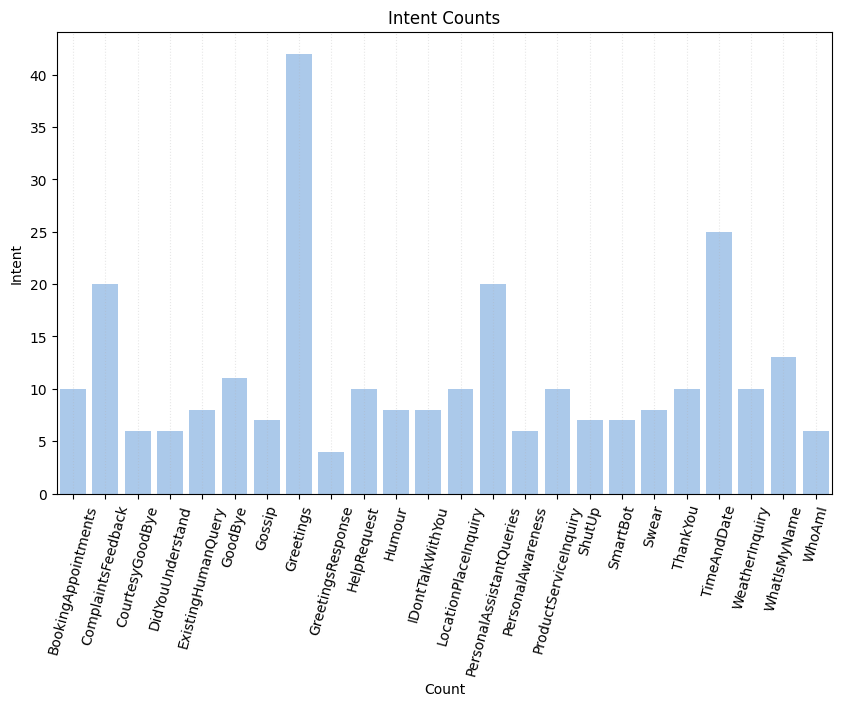

In [27]:
sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
plt.xticks(rotation=75)
sns.barplot(x="intent", y="count", data=intent_counts, orient="v")
plt.title('Intent Counts')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.grid(axis='x', linestyle=':', alpha=0.3)

In [28]:
intent_counts["count"].median()

9.0

In [29]:
df_copy = df_patterns.copy()
df_copy.head()

,text,intent
0,Merhaba,Greetings
0,mrb,Greetings
0,meraba,Greetings
0,merb,Greetings
0,Selam,Greetings


## Data Pre-Processing

In [30]:
import data_preprocessing as prep

In [31]:
df_patterns['clean_text'] = df_patterns['text'].apply(lambda x : prep.data_cleaning(x))
df_patterns

,text,intent,clean_text
0,Merhaba,Greetings,merhaba
0,mrb,Greetings,mrb
0,meraba,Greetings,meraba
0,merb,Greetings,merb
0,Selam,Greetings,selam
...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var


In [32]:
df_patterns['clean_sw'] = df_patterns['text'].apply(lambda x: prep.remove_stopwords(x, stopwords))
df_patterns

,text,intent,clean_text,clean_sw
0,Merhaba,Greetings,merhaba,
0,mrb,Greetings,mrb,mrb
0,meraba,Greetings,meraba,meraba
0,merb,Greetings,merb,merb
0,Selam,Greetings,selam,selam
...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var


In [33]:
df_patterns['clean_sw'][:10]

0            
0         mrb
0      meraba
0        merb
0       selam
0         slm
0        slmz
0      selaam
0       naber
0    nabersin
Name: clean_sw, dtype: object

In [34]:
df_patterns['word_token'] = df_patterns['clean_text'].apply(lambda x: prep.word_tokenize(x))
df_patterns

,text,intent,clean_text,clean_sw,word_token
0,Merhaba,Greetings,merhaba,,[merhaba]
0,mrb,Greetings,mrb,mrb,[mrb]
0,meraba,Greetings,meraba,meraba,[meraba]
0,merb,Greetings,merb,merb,[merb]
0,Selam,Greetings,selam,selam,[selam]
...,...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler,"[bu, ürünün, renk, seçenekleri, neler]"
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır,"[ürün, iadesi, nasıl, yapılır]"
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]"
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var,"[bu, paketin, içeriğinde, neler, var]"


In [35]:
def lemmas(word_list):
    lemma = []
    for word in word_list:
        result = str(morphology.analyzeAndDisambiguate(word).bestAnalysis()[0].getLemmas()[0])
        if result == "UNK":
            lemma.append(result)
        else:
            lemma.append(result)
    return lemma

In [36]:
df_patterns['lemma_token'] = df_patterns['word_token'].apply(lambda x : lemmas(x))
df_patterns

,text,intent,clean_text,clean_sw,word_token,lemma_token
0,Merhaba,Greetings,merhaba,,[merhaba],[merhaba]
0,mrb,Greetings,mrb,mrb,[mrb],[UNK]
0,meraba,Greetings,meraba,meraba,[meraba],[meraba]
0,merb,Greetings,merb,merb,[merb],[UNK]
0,Selam,Greetings,selam,selam,[selam],[selam]
...,...,...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler,"[bu, ürünün, renk, seçenekleri, neler]","[bu, ürün, renk, seçenek, ne]"
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır,"[ürün, iadesi, nasıl, yapılır]","[ürün, iade, nasıl, yap]"
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]","[bu, hizmet, ne, zaman, başla]"
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var,"[bu, paketin, içeriğinde, neler, var]","[bu, paket, içerik, ne, var]"


In [37]:
df__ = prep.balance_data(df_patterns)
df__

,text,intent,clean_text,clean_sw,word_token,lemma_token
0,Merhaba,Greetings,merhaba,,[merhaba],[merhaba]
0,mrb,Greetings,mrb,mrb,[mrb],[UNK]
0,meraba,Greetings,meraba,meraba,[meraba],[meraba]
0,merb,Greetings,merb,merb,[merb],[UNK]
0,Selam,Greetings,selam,selam,[selam],[selam]
...,...,...,...,...,...,...
27,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]","[bu, hizmet, ne, zaman, başla]"
28,Ürün garantisi var mı?,ProductServiceInquiry,ürün garantisi var mı,ürün garantisi var,"[ürün, garantisi, var, mı]","[ürün, garanti, var, mı]"
29,Teslimat seçenekleri nelerdir?,ProductServiceInquiry,teslimat seçenekleri nelerdir,teslimat seçenekleri nelerdir,"[teslimat, seçenekleri, nelerdir]","[teslimat, seçenek, ne]"
30,Bu ürünün fiyatı nedir?,ProductServiceInquiry,bu ürünün fiyatı nedir,ürünün fiyatı nedir,"[bu, ürünün, fiyatı, nedir]","[bu, ürün, fiyat, ne]"


In [39]:
intent_counts2 = df__.groupby("intent").size().reset_index(name="count")
intent_counts2

,intent,count
0,BookingAppointments,42
1,ComplaintsFeedback,42
2,CourtesyGoodBye,42
3,DidYouUnderstand,42
4,ExistingHumanQuery,42
5,GoodBye,42
6,Gossip,42
7,Greetings,42
8,GreetingsResponse,42
9,HelpRequest,42


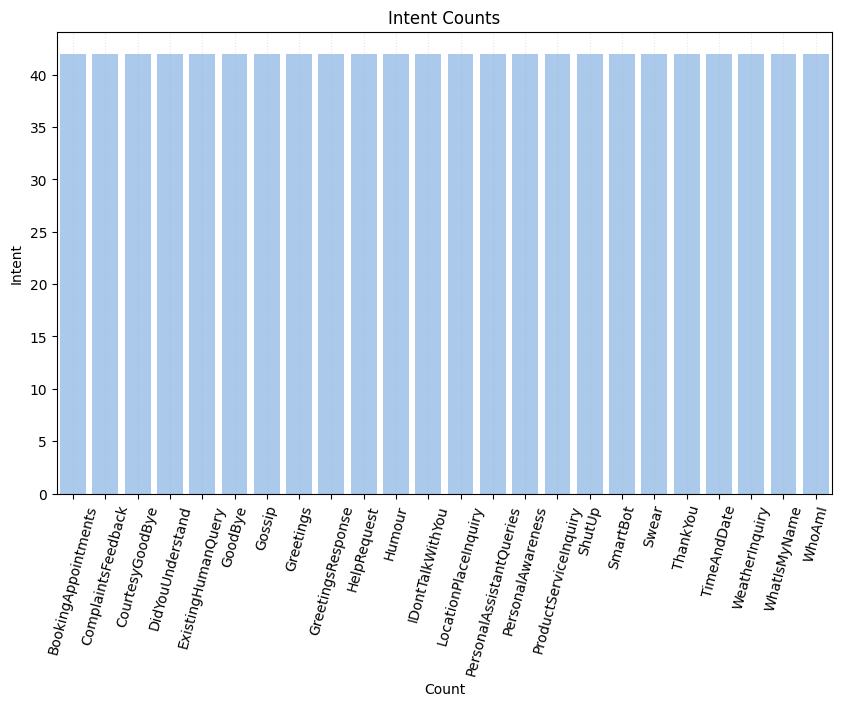

In [40]:
sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
plt.xticks(rotation=75)
sns.barplot(x="intent", y="count", data=intent_counts2, orient="v")
plt.title('Intent Counts')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.grid(axis='x', linestyle=':', alpha=0.3)

## Building a Model

In [41]:
import bert_model as bert

In [42]:
X = df__[["clean_text", "clean_sw", "word_token", "lemma_token"]]
y = df__["intent"]

In [43]:
# Veriyi eğitim ve test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
# Etiketleri sayısal değerlere eşley ve benzersiz etiket sayısını belirle
unique_intents = y.unique()
num_labels = len(unique_intents)
intent_to_num = {intent: num for num, intent in enumerate(unique_intents)}

In [45]:
tokenizer, model = bert.prepare_tokenizer_and_model(num_labels)
train_encodings = bert.tokenize_data(tokenizer, X_train["clean_text"].tolist())
test_encodings = bert.tokenize_data(tokenizer, X_test["clean_text"].tolist())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
train_intents_tensor = bert.convert_intents_to_tensor(y_train, intent_to_num)
test_intents_tensor = bert.convert_intents_to_tensor(y_test, intent_to_num)

In [47]:
train_dataloader, test_dataloader = bert.create_data_loaders(train_encodings, test_encodings, train_intents_tensor, test_intents_tensor)

In [48]:
device = torch.device("cpu")
trained_model = bert.train_model(model, train_dataloader, test_dataloader, device)

Epoch 1/100, Training Loss: 3.2019, Val Loss: 3.0302, Precision: 0.2028, Recall: 0.1381, F1: 0.0914
Epoch 2/100, Training Loss: 2.7945, Val Loss: 2.1764, Precision: 0.7098, Recall: 0.6186, F1: 0.5751
Epoch 3/100, Training Loss: 1.8687, Val Loss: 1.2744, Precision: 0.9238, Recall: 0.9069, F1: 0.9052
Epoch 4/100, Training Loss: 1.1259, Val Loss: 0.6814, Precision: 0.9592, Recall: 0.9550, F1: 0.9544
Epoch 5/100, Training Loss: 0.6728, Val Loss: 0.3694, Precision: 0.9948, Recall: 0.9940, F1: 0.9940
Epoch 6/100, Training Loss: 0.3934, Val Loss: 0.2104, Precision: 0.9948, Recall: 0.9940, F1: 0.9940
Epoch 7/100, Training Loss: 0.2453, Val Loss: 0.1340, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 8/100, Training Loss: 0.1645, Val Loss: 0.0940, Precision: 0.9948, Recall: 0.9940, F1: 0.9940
Epoch 9/100, Training Loss: 0.1235, Val Loss: 0.0727, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 10/100, Training Loss: 0.0973, Val Loss: 0.0564, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

In [49]:
accuracy, predicted_intents = bert.evaluate_model(trained_model, test_dataloader, device,intent_to_num)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 1.0000


In [50]:
test_texts = [  "naber", 
                "isminiiiii söyleeeee", 
                "dedikodun var mı?",
                "bugün hava kaç derece", 
                "sellllaaaaammmm",
                "Tenceren var mı?",
                "bilinçli olduğunu kanıtla",
                "Abla bays biliyosunnn", 
                "Beni görüyor musun?",
                "hangi gün bugün",
                "bana yeni bir mekan bul",
                "çarşamba ne zaman",
                "bunun hakında bilgi alabilir miyim?",
                "benim adımı hatırla",
                "eyyyyyvvaaaallllllllaaaaaaahhhh",
                "tamam mı?"
                ]
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')

with torch.no_grad():
    input_ids = test_encodings['input_ids'].to(device)
    attention_mask = test_encodings['attention_mask'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

num_to_intent = {num: intent for intent, num in intent_to_num.items()}
predicted_intents = [num_to_intent[pred] for pred in predictions]
print(predicted_intents)

['Greetings', 'WhatIsMyName', 'Gossip', 'WeatherInquiry', 'Greetings', 'DidYouUnderstand', 'PersonalAwareness', 'GoodBye', 'WhoAmI', 'TimeAndDate', 'PersonalAssistantQueries', 'TimeAndDate', 'HelpRequest', 'WhatIsMyName', 'GoodBye', 'DidYouUnderstand']
